In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

The purpose of this analysis was to investigate possible outliers in the WOWTDR_predat dataset. Some initial filtering and exploration of the data was conducted to see if any anomalies were immediately present. From there began the process of building a model that could help identify possible anomalies as well as a sensitivity analysis of the model itself to help fine tune its parameters. Once the model was operational and could produce possible anomalies cross validation of these datasets was conducted to determine the likleyhood that the data produced were indeed anomalies. This included removing these data from the original data and running it through a classification algorithm to test model performance when 'anomalies' were removed. Finally, once data could be labeled, an AutoEncoder model was built to classify future data based on the reconstruction error of the flagged data, creating a real time anomaly detector for future data.  

In [223]:
data_big = pd.read_csv('WOWTDR_prepdat.csv')

In [224]:
data_big

,ID,obs,Bedrock_Depth_fix,Dist_Mouth_m,DrainDens,Drain_Class_fix,FAC_sqkm,Group,HAND_1,HUC12,...,tp_vrm,tph_ge_3_2017,tphc_ge_3_2017,tphh_ge_3_2017,upstrm_reachID,vpdmax_yr_m_0,vpdmax_yr_m_1,vpdmax_yr_m_2,x,y
0,1521,Wet,127.005844,11747.430511,10.703786,2.002337,0.017350,80,36.513630,171003020502,...,0.013455,633.265198,410.841125,222.627335,None,36.199806,34.117901,34.970486,502852.865537,4.754270e+06
1,1522,Wet,105.312111,11741.217308,3.815225,2.245037,0.188075,80,49.883854,171003020502,...,0.009777,938.024292,608.747070,329.261536,None,38.442825,36.223309,36.631279,502802.865537,4.754275e+06
2,1522,Wet,105.312111,11741.217308,3.815225,2.245037,0.188075,80,49.883854,171003020502,...,0.009777,938.024292,608.747070,329.261536,None,38.442825,36.223309,36.631279,502802.865537,4.754275e+06
3,1523,Wet,150.085037,11892.283325,3.016542,2.001134,0.279025,80,60.034954,171003020502,...,0.008055,1006.149658,118.900230,887.236389,None,38.138504,35.914341,36.540077,502907.865537,4.754395e+06
4,1524,Wet,143.067368,5062.140472,3.584770,2.001104,1.327500,80,41.273933,171003020502,...,0.004564,1113.289307,844.548340,268.824402,None,38.361652,36.583889,36.537746,498227.865537,4.755385e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,1229,Wet,0.000000,12822.910633,4.597613,3.907427,1.772050,80,2.797891,171002030902,...,0.001237,259.459900,196.853378,62.410049,None,7.153027,9.315274,10.443623,430492.865537,5.016200e+06
2940,1230,Wet,0.000000,12167.138988,6.747243,1.000376,0.041275,80,22.454512,171002030902,...,0.014645,666.590759,612.020691,54.322666,None,11.350513,12.179909,12.822898,430577.865537,5.016925e+06
2941,1231,Wet,0.000000,11700.656665,2.106842,3.143033,0.096825,80,8.850307,171002030902,...,0.003168,627.400757,466.121155,161.126389,None,8.025269,10.124486,11.113398,429947.865537,5.017105e+06
2942,1232,Wet,0.000000,11751.367343,10.722786,1.000667,0.012350,80,34.278549,171002030902,...,0.008305,538.705139,453.737823,84.842560,None,10.696782,12.747306,13.148885,429797.865537,5.017155e+06


In [225]:
data = data_big[['ID', 'obs','FAC_sqkm', 'elev','d_slp20_m', 'ppt_sum_yr_m_0', 'ppt_yr_m_0', 'seg_slope_perc', 'STRAHLER', 'SumUpSlpLen_km']]
data= data.drop_duplicates().reset_index(drop=True)

In [226]:
data

,ID,obs,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km
0,1521,Wet,0.017350,495.685852,0.191701,907.394043,1.760924,0.143396,1,0.213852
1,1522,Wet,0.188075,493.571167,0.182880,893.925049,2.039627,0.114214,2,0.791475
2,1523,Wet,0.279025,527.804443,0.282713,884.830017,1.130813,0.027854,2,0.888181
3,1524,Wet,1.327500,331.478577,0.001914,903.159729,1.332044,-0.000350,3,4.923404
4,1525,Wet,1.108325,355.276337,0.060223,901.722046,1.309967,0.099989,3,4.146109
...,...,...,...,...,...,...,...,...,...,...
2600,1229,Wet,1.772050,180.377106,0.007826,1987.466064,14.422233,0.000000,3,8.286954
2601,1230,Wet,0.041275,208.910355,0.242794,2762.189453,15.028871,0.007385,1,0.288175
2602,1231,Wet,0.096825,218.520081,0.114993,2064.167480,14.570926,0.043012,1,0.208603
2603,1232,Wet,0.012350,211.710831,0.429275,2475.022217,14.767077,0.712601,1,0.144373


# Initial Exploration

Plots compare all features to eachother to look for any initial patterns or trends that might be present in the data

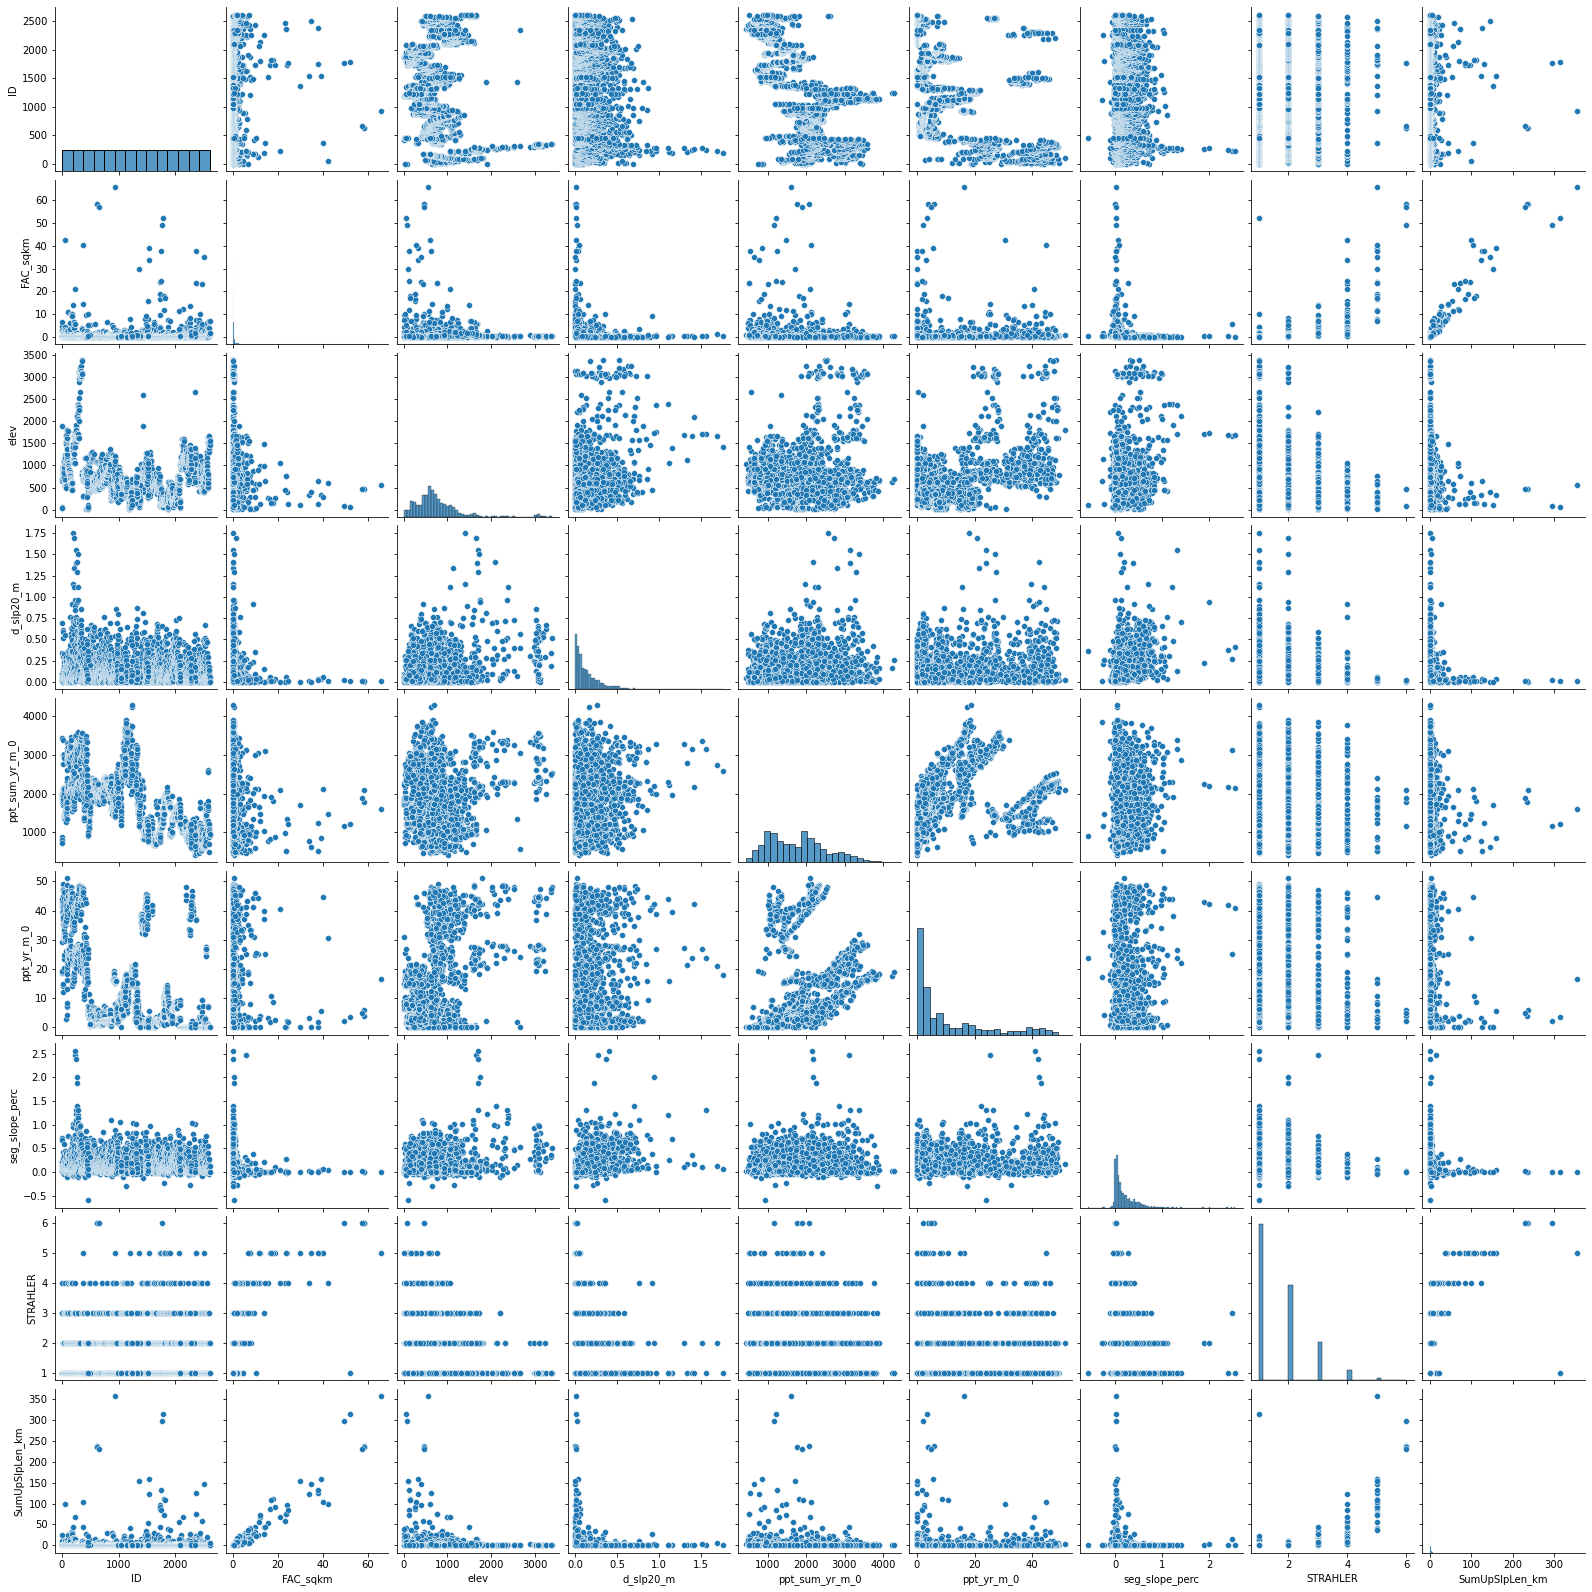

In [6]:
sns.pairplot(data)

Text(0.5, 1.0, 'ppt_sum_yr_m_0 vs ppt_yr_m_0')

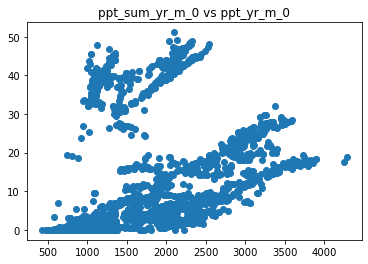

In [7]:
plt.scatter(data['ppt_sum_yr_m_0'],data['ppt_yr_m_0'])
plt.title('ppt_sum_yr_m_0 vs ppt_yr_m_0')

Text(0.5, 1.0, 'elev vs SumUpSlpLen_km')

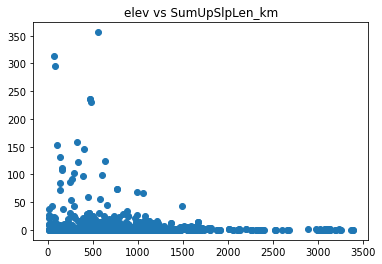

In [8]:
plt.scatter(data['elev'],data['SumUpSlpLen_km'])
plt.title('elev vs SumUpSlpLen_km')

More upstream segment lengths at lower elevations

Text(0.5, 1.0, 'elev vs seg_slope_perc')

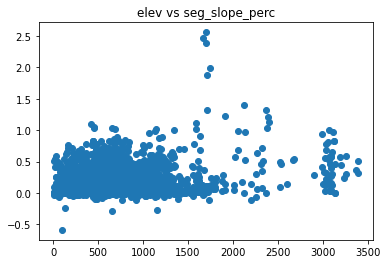

In [9]:
plt.scatter(data['elev'],data['seg_slope_perc'])
plt.title('elev vs seg_slope_perc')

Text(0.5, 1.0, 'STRAHLER vs elev')

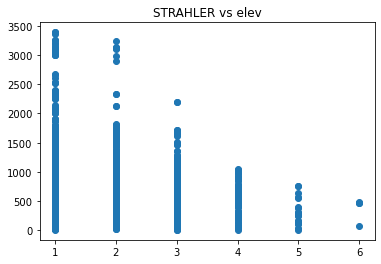

In [10]:
plt.scatter(data['STRAHLER'],data['elev'])
plt.title('STRAHLER vs elev')

More tributaries at lower eleveations?

# Anomaly Detection

In [11]:
data['ppt_diff']=data['ppt_sum_yr_m_0']-data['ppt_yr_m_0']

In [12]:
col_means = data.mean()
col_stds = data.std()

summary_df = pd.DataFrame({'Mean': col_means, 'Std': col_stds})

summary_df = summary_df.drop(['ID', 'STRAHLER'])
summary_df['+std'] = summary_df['Mean']+summary_df['Std']
summary_df['-std'] = summary_df['Mean']-summary_df['Std']
summary_df['+2std'] = summary_df['Mean']+2*summary_df['Std']
summary_df['-2std'] = summary_df['Mean']-2*summary_df['Std']
summary_df

# mean, standard deviation, mean+-standard deviation and mean +-2 standard devaitions

C:\Users\nakae\AppData\Local\Temp\ipykernel_8748\3547297296.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  col_means = data.mean()
C:\Users\nakae\AppData\Local\Temp\ipykernel_8748\3547297296.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  col_stds = data.std()


,Mean,Std,+std,-std,+2std,-2std
FAC_sqkm,0.910745,3.851700,4.762445,-2.940955,8.614144,-6.792655
elev,749.085180,512.349746,1261.434926,236.735434,1773.784672,-275.614312
d_slp20_m,0.160687,0.179800,0.340487,-0.019114,0.520287,-0.198914
ppt_sum_yr_m_0,1767.541320,748.607049,2516.148368,1018.934271,3264.755417,270.327222
ppt_yr_m_0,11.059396,13.621101,24.680497,-2.561705,38.301599,-16.182807
seg_slope_perc,0.175917,0.226533,0.402450,-0.050617,0.628983,-0.277150
SumUpSlpLen_km,3.414036,16.789147,20.203183,-13.375110,36.992330,-30.164257
ppt_diff,1756.481924,744.257688,2500.739611,1012.224236,3244.997299,267.966548


In [13]:
# potential anomalies based on data with stats above and below the mean+1std

pot_anom = data[((data.d_slp20_m>summary_df['+std'][2])) & 
     ((data.elev>summary_df['+std'][1])|(data.elev<summary_df['-std'][1])) &
     ((data.ppt_sum_yr_m_0>summary_df['+std'][3])|(data.ppt_sum_yr_m_0<summary_df['-std'][3])) &
     ((data.ppt_yr_m_0>summary_df['+std'][4])|(data.ppt_yr_m_0<summary_df['-std'][4])) &
     ((data.seg_slope_perc>summary_df['+std'][5])|(data.seg_slope_perc<summary_df['-std'][5]))]
pot_anom


,ID,obs,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km,ppt_diff
1544,248,Dry,0.108875,1587.604004,0.757780,3082.483643,24.751621,1.107324,1,0.575683,3057.732021
1598,302,Wet,0.144500,2254.352295,0.476037,3314.685303,27.971653,-0.060525,1,0.716570,3286.713650
1607,311,Dry,0.212050,3117.998535,0.496126,3265.708740,27.751223,0.820703,2,0.891833,3237.957518
1608,312,Wet,0.215325,3105.280273,0.494346,3267.611572,27.756277,0.651074,2,0.916987,3239.855295
1609,313,Dry,0.090350,3073.343262,0.550390,3219.040283,26.803871,0.454475,1,0.121647,3192.236412
1610,314,Dry,0.093000,3068.485107,0.659546,3219.020996,26.805405,0.999854,1,0.135978,3192.215591
1611,315,Dry,0.104025,3192.048096,0.573184,3191.222412,26.834063,0.574707,1,0.253522,3164.388350
1634,338,Dry,0.135750,3038.083740,0.578807,3458.892822,27.587765,0.686874,1,0.464932,3431.305058
1649,353,Dry,0.174225,3391.104980,0.518920,2532.256348,48.188431,0.507227,1,0.330415,2484.067917


In [14]:
# high elevation with negative seg_slope_perc
data[(data.elev>summary_df['+2std'][1])&
    (data.seg_slope_perc<0)]

,ID,obs,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km,ppt_diff
1574,278,Wet,0.512575,2201.536865,0.019360,3350.088135,27.985580,-0.111625,3,1.795816,3322.102554
1584,288,Wet,0.111600,2363.571777,0.959123,3274.350342,26.963144,-0.004248,1,0.284300,3247.387197
1598,302,Wet,0.144500,2254.352295,0.476037,3314.685303,27.971653,-0.060525,1,0.716570,3286.713650
1640,344,Wet,0.232125,3133.945312,0.002933,2379.297363,44.476463,-0.001001,1,0.313963,2334.820900
1641,345,Wet,0.232375,3133.952393,0.029980,3497.787354,27.410370,-0.007043,1,0.321034,3470.376984


Should seg_slope_perc be negative? essentially level slope if negative? How do they collect slope pct, how accurate are the instruments used?

In [15]:
# data at high elev with multiple tributaries and small sum of upstream seg lengths
# data at elev > mean+std, strahler >=3 and SumUpSlpLen_km < mean
data[((data.elev>summary_df['+std'][1]))&
    ((data.STRAHLER>=3)) &
    ((data.SumUpSlpLen_km<summary_df['Mean'][6]))]

,ID,obs,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km,ppt_diff
1123,1502,Wet,0.557950,1272.971680,0.041235,1301.452271,44.385063,0.061147,3,2.230512,1257.067207
1573,277,Wet,0.506175,2202.761475,0.050000,2276.082764,43.643147,0.144922,3,1.778685,2232.439617
1574,278,Wet,0.512575,2201.536865,0.019360,3350.088135,27.985580,-0.111625,3,1.795816,3322.102554
1575,279,Wet,0.642000,1716.826416,0.040112,2205.277832,42.937809,0.062573,3,2.662708,2162.340023
1576,280,Wet,0.643350,1716.428467,0.231775,3212.751221,25.510551,0.016699,3,2.672709,3187.240669
1770,2211,Wet,1.675450,1275.023315,0.054032,1022.290405,0.000000,0.040381,3,3.053738,1022.290405
1856,2595,Dry,2.245050,1662.599365,0.158131,1229.502563,0.000000,-0.037600,3,2.782382,1229.502563


In [16]:
data[data['seg_slope_perc']<-0.2]

,ID,obs,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km,ppt_diff
1821,2263,Dry,1.686625,1156.673340,0.214732,1178.891968,32.592640,-0.274878,1,1.926208,1146.299328
2079,1800,Wet,0.107600,133.414291,0.262671,1473.087158,4.194302,-0.234965,2,0.854868,1468.892857
2469,1127,Wet,0.241975,651.704956,0.015472,3850.409668,17.375002,-0.283008,2,1.986199,3833.034666
2586,457,Wet,0.277525,102.153717,0.360407,917.575012,23.823397,-0.588933,1,1.143649,893.751616


## Isolation Forest

To identify anomalies in this data an Isolation Forest model was built and employed. Isolation Forests, similar to Random Forests, are built based on decision trees. The goal of isolation forests is to “isolate” outliers. The algorithm is built on the premise that anomalous points are easier to isolate than regular points through random partitioning of data. Anamolous points will have short paths to leaves, making them easier to isolate,  while interior points on an average will have a significantly longer path to the leaf.


In [17]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.impute import SimpleImputer

In [18]:
data.head()

,ID,obs,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km,ppt_diff
0,1521,Wet,0.017350,495.685852,0.191701,907.394043,1.760924,0.143396,1,0.213852,905.633119
1,1522,Wet,0.188075,493.571167,0.182880,893.925049,2.039627,0.114214,2,0.791475,891.885422
2,1523,Wet,0.279025,527.804443,0.282713,884.830017,1.130813,0.027854,2,0.888181,883.699204
3,1524,Wet,1.327500,331.478577,0.001914,903.159729,1.332044,-0.000350,3,4.923404,901.827685
4,1525,Wet,1.108325,355.276337,0.060223,901.722046,1.309967,0.099989,3,4.146109,900.412079


In [19]:
data.obs[data.obs=='Wet']=1
data.obs[data.obs=='Dry']=0
data['obs']=data.obs.apply(pd.to_numeric)


C:\Users\nakae\AppData\Local\Temp\ipykernel_8748\447069719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Wet']=1
C:\Users\nakae\AppData\Local\Temp\ipykernel_8748\447069719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs[data.obs=='Dry']=0


In [20]:
X = data.drop(['obs','ID'],axis=1)
y = data['obs']

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [22]:
numerical_feats = ['FAC_sqkm','elev','d_slp20_m','ppt_sum_yr_m_0','ppt_yr_m_0','seg_slope_perc','SumUpSlpLen_km','ppt_diff']

In [23]:
num_processor = Pipeline(steps=[
    ('scaler', StandardScaler())  
])

In [24]:
feat_processor = ColumnTransformer(transformers = [
    ('num_pipe', num_processor,numerical_feats)
])

In [25]:
model = IsolationForest(random_state=50)

In [26]:
pipe = Pipeline(steps=[
    ('feature_processor', feat_processor),
    ('model', model)
])
pipe

Pipeline(steps=[('feature_processor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['FAC_sqkm', 'elev',
                                                   'd_slp20_m',
                                                   'ppt_sum_yr_m_0',
                                                   'ppt_yr_m_0',
                                                   'seg_slope_perc',
                                                   'SumUpSlpLen_km',
                                                   'ppt_diff'])])),
                ('model', IsolationForest(random_state=50))])

In [27]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('feature_processor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['FAC_sqkm', 'elev',
                                                   'd_slp20_m',
                                                   'ppt_sum_yr_m_0',
                                                   'ppt_yr_m_0',
                                                   'seg_slope_perc',
                                                   'SumUpSlpLen_km',
                                                   'ppt_diff'])])),
                ('model', IsolationForest(random_state=50))])

## Model Sensitivity Analysis

The purpose of the model sensitivity analysis was to hone in on what parameters have the largest affect on model output. The main parameters of the Isolation forest consist of n_estimators; the number of base estimators in the ensemble, max_samples; the number of samples to draw from X to train each base estimator, contamination; the amount of contamination of the data set, i.e. the proportion of outliers in the data set, and max_features; the number of features to draw from X to train each base estimator. Each parameter was tested on a wide range of values while the other parameters were held constant. The number of outputs was recorded and plotted for each test. 


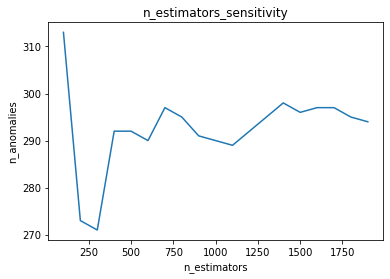

In [28]:
#n_estimators; the number of base estimators in the ensemble
n_estimators_values = list(range(100,2000,100))
num_anoms_est = []
for n in n_estimators_values:
    param_grid = {'model__n_estimators': [n], 
                  'model__max_samples': ['auto'], 
                  'model__contamination': ['auto'], 
                  'model__max_features': [4], 
                  'model__bootstrap': [True], 
                  'model__n_jobs': [-1]}

    grid_search = GridSearchCV(pipe, 
                            param_grid,
                            scoring="neg_mean_squared_error", 
                            refit=True,
                            cv=10, 
                            return_train_score=True,
                            error_score='raise')
    grid_search.fit(X_train, y_train)


    best_model=grid_search.best_estimator_

    y_pred = best_model.fit_predict(X)
    iforest_anom=X[y_pred==-1]
    #how many anomalies does it predict
    num_anoms_est.append(len(iforest_anom))
    
plt.plot(n_estimators_values,num_anoms_est)
plt.title('n_estimators_sensitivity')
plt.xlabel('n_estimators')
plt.ylabel('n_anomalies')
#plt.savefig('n_estimators_sens')

Text(0, 0.5, 'n_anomalies')

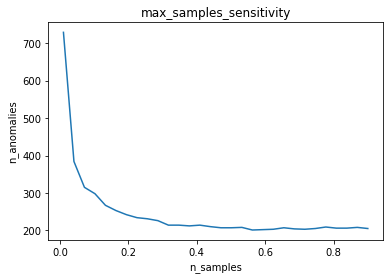

In [36]:
#max_samples; the number of samples to draw from X to train each base estimator
max_samples_values = list(np.linspace(.9,.01,30))
num_anoms_samp = []
for n in max_samples_values:
    param_grid = {'model__n_estimators': [1200], 
                  'model__max_samples': [n], 
                  'model__contamination': ['auto'], 
                  'model__max_features': [4], 
                  'model__bootstrap': [True], 
                  'model__n_jobs': [-1]}

    grid_search = GridSearchCV(pipe, 
                            param_grid,
                            scoring="neg_mean_squared_error", 
                            refit=True,
                            cv=10, 
                            return_train_score=True,
                            error_score='raise')
    grid_search.fit(X_train, y_train)


    best_model=grid_search.best_estimator_

    y_pred = best_model.fit_predict(X)
    iforest_anom=X[y_pred==-1]
    #how many anomalies does it predict
    num_anoms_samp.append(len(iforest_anom))
    
plt.plot(max_samples_values,num_anoms_samp)
plt.title('max_samples_sensitivity')
plt.xlabel('n_samples')
plt.ylabel('n_anomalies')
#plt.savefig('max_samples_sens')

In [35]:
len(data)*.1

260.5

C:\Users\nakae\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


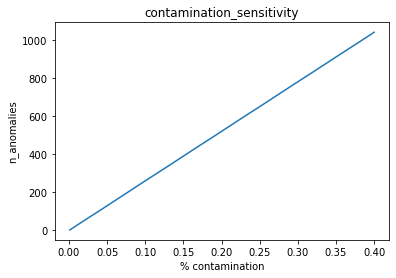

In [30]:
#contamination; the amount of contamination of the data set,
#i.e. the proportion of outliers in the data set
contamination_values = list(np.linspace(.001,.4,20))
num_anoms_cont=[]
for contam in contamination_values:
    param_grid = {'model__n_estimators': [1200], 
                  'model__max_samples': ['auto'], 
                  'model__contamination': [contam], 
                  'model__max_features': [4], 
                  'model__bootstrap': [True], 
                  'model__n_jobs': [-1]}

    grid_search = GridSearchCV(pipe, 
                            param_grid,
                            scoring="neg_mean_squared_error", 
                            refit=True,
                            cv=10, 
                            return_train_score=True,
                            error_score='raise')
    grid_search.fit(X_train, y_train)


    best_model=grid_search.best_estimator_

    y_pred = best_model.fit_predict(X)

    iforest_anom=X[y_pred==-1]
    num_anoms_cont.append(len(iforest_anom))
    
    
plt.plot(contamination_values, num_anoms_cont)
plt.title('contamination_sensitivity')
plt.xlabel('% contamination')
plt.ylabel('n_anomalies')
#plt.savefig('contam_sens')

Text(0, 0.5, 'n_anomalies')

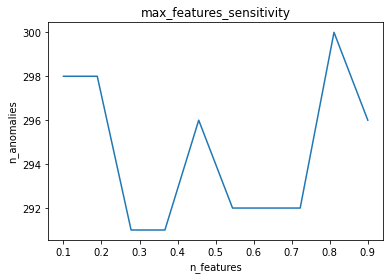

In [32]:
#max_features; the number of features to draw from X 
#to train each base estimator.
max_features_values = list(np.linspace(.1,.9,10))
num_anoms_feats = []
for n in max_features_values:
    param_grid = {'model__n_estimators': [1200], 
                  'model__max_samples': ['auto'], 
                  'model__contamination': ['auto'], 
                  'model__max_features': [n], 
                  'model__bootstrap': [True], 
                  'model__n_jobs': [-1]}

    grid_search = GridSearchCV(pipe, 
                            param_grid,
                            scoring="neg_mean_squared_error", 
                            refit=True,
                            cv=10, 
                            return_train_score=True,
                            error_score='raise')
    grid_search.fit(X_train, y_train)


    best_model=grid_search.best_estimator_

    y_pred = best_model.fit_predict(X)
    iforest_anom=X[y_pred==-1]
    #how many anomalies does it predict
    num_anoms_feats.append(len(iforest_anom))
    
plt.plot(max_features_values,num_anoms_feats)
plt.title('max_features_sensitivity')
plt.xlabel('n_features')
plt.ylabel('n_anomalies')
#plt.savefig('max_features_sens')

The results of the sensitivity analysis show contamination and max_features play the largest role in the size of the model output. Going forward these will be the main parameters used to determine the model output.

## Grid search CV

This initial gridsearch cross validation was performed to find what were the best values to use for these parameters specifically contamination and max_features. The model would then be refit using these determined best values to produce a dataset of possible anomalies. 

In [28]:
 param_grid = {'model__n_estimators': [1300], 
                  'model__max_samples': ['auto',0.5], 
                  'model__contamination': ['auto',0.1,0.08,0.05,0.03,0.01,], 
                  'model__max_features': [1,2,3,4,5,6,7], 
                  'model__bootstrap': [True], 
                  'model__n_jobs': [-1]}
grid_search = GridSearchCV(pipe, 
                            param_grid,
                            scoring="neg_mean_squared_error", 
                            refit=True,
                            cv=10, 
                            return_train_score=True,
                            error_score='raise')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('feature_processor',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['FAC_sqkm',
                                                                          'elev',
                                                                          'd_slp20_m',
                                                                          'ppt_sum_yr_m_0',
                                                                          'ppt_yr_m_0',
                                                                          'seg_slope_perc',
                                                                          'SumUpSlpLen_km',
                                                                          'ppt_diff'])])),
                                       ('model',
                                        IsolationForest(random_state=50))]),
             param_grid={'model__bootstrap': [True],
                         'model__contamination': ['auto', 0.1, 0.08, 0.05, 0.03,
                                                  0.01],
                         'model__max_features': [1, 2, 3, 4, 5, 6, 7],
                         'model__max_samples': ['auto', 0.5],
                         'model__n_estimators': [1300], 'model__n_jobs': [-1]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [29]:
best_model=grid_search.best_estimator_

In [30]:
grid_search.best_params_

{'model__bootstrap': True,
 'model__contamination': 0.01,
 'model__max_features': 4,
 'model__max_samples': 'auto',
 'model__n_estimators': 1300,
 'model__n_jobs': -1}

In [31]:
y_pred = best_model.fit_predict(X)
iforest_anoms=X[y_pred==-1]

In [32]:
iforest_anoms

,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km,ppt_diff
12,33.766476,334.247162,0.014096,775.579346,3.139964,0.018092,4,123.106017,772.439382
25,39.007450,319.913300,0.035834,859.324707,5.494297,0.034281,5,158.811139,853.830410
206,24.060650,389.996918,0.000617,1357.646362,2.333288,-0.008299,5,97.257239,1355.313074
228,23.827650,764.076294,0.012292,514.178528,0.000000,0.020935,5,73.944199,514.178528
229,23.832150,763.677185,0.054826,514.160767,0.000000,0.272666,5,73.965674,514.160767
235,37.744324,636.994141,0.035942,524.438354,0.000000,0.018213,5,124.997325,524.438354
372,34.897350,399.470551,0.002422,633.875732,0.000000,-0.002899,5,145.503189,633.875732
619,58.419098,468.775116,0.000000,2085.922852,5.800645,0.000000,6,236.286066,2080.122207
620,58.281948,469.330139,0.017068,1773.740967,3.805324,-0.004517,6,235.529515,1769.935642
649,57.247498,476.457214,0.012598,1882.855835,4.792438,0.016210,6,230.065143,1878.063397


This does produce a dataset of possible anomalies. However, because the gridsearchCV determines its best parameters based on negative mean squared error, the smaller the contamination value the better the model will perform. Therefore further cross validation  was needed to produce a more likley dataset of anomalies.

## Datasets with varrying parameters

The model was used to create 42 datasets of possible anomalies. Each dataset was produced using different contamination and max_features values. From there the frequency with which data appeared throughout these datasets was determined. The frequency corresponding to the likelihood that the data was an anomaly. Each dataset can be thought of as a refining of potential anomalies, the larger you get the broader the net your are casting to find anomalies.

In [33]:
contamination_values = ['auto',0.1,0.08,0.05,0.03,0.01]
max_features_values = [1,2,3,4,5,6,7]
iforest_anom_list=[]
for contam in contamination_values:
    for feats in max_features_values:
        param_grid = {'model__n_estimators': [1200], 
                      'model__max_samples': ['auto'], 
                      'model__contamination': [contam], 
                      'model__max_features': [feats], 
                      'model__bootstrap': [True], 
                      'model__n_jobs': [-1]}

        grid_search = GridSearchCV(pipe, 
                                param_grid,
                                scoring="neg_mean_squared_error", 
                                refit=True,
                                cv=10, 
                                return_train_score=True,
                                error_score='raise')
        grid_search.fit(X_train, y_train)


        best_model=grid_search.best_estimator_

        y_pred = best_model.fit_predict(X)

        iforest_anom=X[y_pred==-1]
        iforest_anom_list.append(iforest_anom)

In [34]:
# number of datasets produced 
len(iforest_anom_list)

42

In [35]:
# pull out the indexes of all the points in all the lists 
anom_index_list = []
for i in range(len(iforest_anom_list)):
    anom_index=list(iforest_anom_list[i].index)
    anom_index_list.append(anom_index)

flattened_data = [value for sublist in anom_index_list for value in sublist]

In [36]:
from collections import Counter
frequency = Counter(flattened_data)
sorted_counts = frequency.most_common()
frequency_lists = []
current_frequency=None
current_list = []
for value, count in sorted_counts:
    if count != current_frequency:
        if current_list:
            frequency_lists.append(current_list)
        current_frequency = count
        current_list=[]
    current_list.append(value)
frequency_lists.append(current_list)


In [37]:
# datasets that get increasingly more refined
anomaly_range=[]
for i in range(len(frequency_lists)):
    freq_list = []
    for j in range(i+1):
        freq_list.extend(frequency_lists[j])
    anomaly_range.append(freq_list)
    

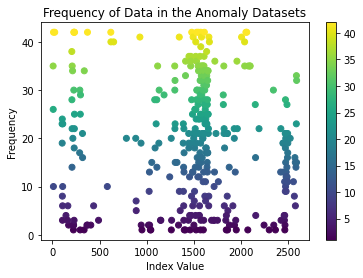

In [38]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the occurrences of each value in the list
value_counts = Counter(flattened_data)

# Create lists for x and y coordinates
x = list(value_counts.keys())
y = list(value_counts.values())

# Create a list of frequencies to assign colors
frequencies = [value_counts[val] for val in x]

# Plot the scatter plot with color-coded points
plt.scatter(x, y, c=frequencies, cmap='viridis')
plt.xlabel('Index Value')
plt.ylabel('Frequency')
plt.title('Frequency of Data in the Anomaly Datasets')
plt.colorbar()
plt.show()

In [94]:
common_anoms_list = []
for i in range(len(anomaly_range)):
    common_anoms_list.append(data[data.index.isin(anomaly_range[i])])

In [227]:
#data pts that occur in all datasets
common_anoms_list[0]

,ID,obs,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km
12,1533,Dry,33.766476,334.247162,0.014096,775.579346,3.139964,0.018092,4,123.106017
25,1546,Wet,39.007450,319.913300,0.035834,859.324707,5.494297,0.034281,5,158.811139
228,2363,Wet,23.827650,764.076294,0.012292,514.178528,0.000000,0.020935,5,73.944199
229,2364,Wet,23.832150,763.677185,0.054826,514.160767,0.000000,0.272666,5,73.965674
235,2370,Wet,37.744324,636.994141,0.035942,524.438354,0.000000,0.018213,5,124.997325
372,2507,Dry,34.897350,399.470551,0.002422,633.875732,0.000000,-0.002899,5,145.503189
619,627,Dry,58.419098,468.775116,0.000000,2085.922852,5.800645,0.000000,6,236.286066
1476,180,Wet,9.067100,452.194153,0.914958,2027.247559,41.123760,0.389785,4,28.232490
1528,232,Wet,5.608425,1669.413940,0.270914,3118.552002,25.235018,2.473441,3,15.008474
1546,250,Wet,0.098125,1705.360718,1.552593,3146.805176,23.902178,1.312532,1,0.487000


In [228]:
# for i , df in enumerate(common_anoms_list):
#     df.to_csv(f'anoms_{i}.csv', index=False)

In [229]:
# create a column of anomalys (-1 if anomaly 1 otherwise)
data['anomaly']=np.where(data.isin(common_anoms_list[41]).all(axis=1),-1,1)

In [230]:
anomalies = data[data['anomaly']==-1]
anomalies

,ID,obs,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km,anomaly
8,1529,Wet,15.723049,254.702469,0.006439,777.101562,3.155749,0.006860,4,53.912409,-1
9,1530,Wet,7.739100,289.862122,0.004159,757.118774,3.125610,0.037506,4,24.736420,-1
11,1532,Dry,4.051450,354.428833,0.020584,776.714722,3.090779,0.050379,3,16.954465,-1
12,1533,Dry,33.766476,334.247162,0.014096,775.579346,3.139964,0.018092,4,123.106017,-1
25,1546,Wet,39.007450,319.913300,0.035834,859.324707,5.494297,0.034281,5,158.811139,-1
...,...,...,...,...,...,...,...,...,...,...,...
2580,1325,Wet,0.726225,298.355042,0.512149,3082.601318,12.003325,0.031985,3,4.049752,-1
2584,1329,Wet,0.768825,924.545532,0.868367,3146.742676,9.426083,0.082899,2,1.716263,-1
2585,456,Wet,10.046675,35.693836,0.039999,1018.267456,25.464037,0.055327,1,23.565045,-1
2586,457,Wet,0.277525,102.153717,0.360407,917.575012,23.823397,-0.588933,1,1.143649,-1


In [231]:
normal_data = data.drop(anomalies.index)

## Violin plots

The anomalies dataset used to create these plots was the 'anomalies_41', which is the largest most unrefined anomalies dataset.

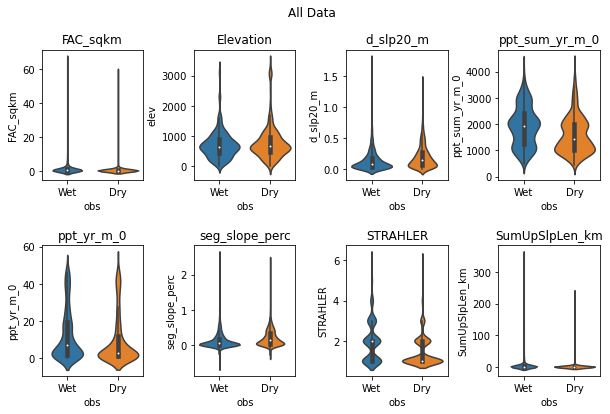

In [110]:

fig, ax = plt.subplots(2,4, figsize = (10,6))
ax = ax.flatten()

sns.violinplot(x='obs', y='FAC_sqkm', data=data, ax=ax[0])
sns.violinplot(x='obs', y='elev', data=data, ax=ax[1])
sns.violinplot(x='obs', y='d_slp20_m', data=data, ax=ax[2])
sns.violinplot(x='obs', y='ppt_sum_yr_m_0', data=data, ax=ax[3])
sns.violinplot(x='obs', y='ppt_yr_m_0', data=data, ax=ax[4])
sns.violinplot(x='obs', y='seg_slope_perc', data=data, ax=ax[5])
sns.violinplot(x='obs', y='STRAHLER', data=data, ax=ax[6])
sns.violinplot(x='obs', y='SumUpSlpLen_km', data=data, ax=ax[7] )

ax[0].set_title('FAC_sqkm')
ax[1].set_title('Elevation')
ax[2].set_title('d_slp20_m')
ax[3].set_title('ppt_sum_yr_m_0')
ax[4].set_title('ppt_yr_m_0')
ax[5].set_title('seg_slope_perc')
ax[6].set_title('STRAHLER')
ax[7].set_title('SumUpSlpLen_km')

fig.subplots_adjust(hspace=0.5,wspace=0.5)
fig.suptitle('All Data')
plt.savefig('all_data')

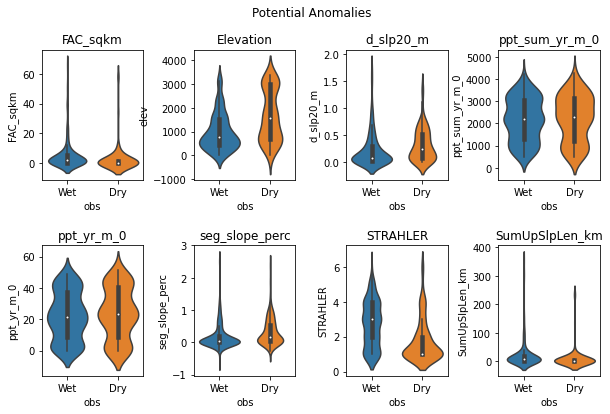

In [111]:
fig, ax = plt.subplots(2,4, figsize = (10,6))
ax = ax.flatten()

sns.violinplot(x='obs', y='FAC_sqkm', data=anomalies, ax=ax[0], label = 'FAC_sqkm')
sns.violinplot(x='obs', y='elev', data=anomalies, ax=ax[1], label = 'Elev')
sns.violinplot(x='obs', y='d_slp20_m', data=anomalies, ax=ax[2], label = 'd_slp20_m')
sns.violinplot(x='obs', y='ppt_sum_yr_m_0', data=anomalies, ax=ax[3], label = 'Elev')
sns.violinplot(x='obs', y='ppt_yr_m_0', data=anomalies, ax=ax[4], label = 'Elev')
sns.violinplot(x='obs', y='seg_slope_perc', data=anomalies, ax=ax[5], label = 'Elev')
sns.violinplot(x='obs', y='STRAHLER', data=anomalies, ax=ax[6], label = 'Elev')
sns.violinplot(x='obs', y='SumUpSlpLen_km', data=anomalies, ax=ax[7], label = 'Elev')

ax[0].set_title('FAC_sqkm')
ax[1].set_title('Elevation')
ax[2].set_title('d_slp20_m')
ax[3].set_title('ppt_sum_yr_m_0')
ax[4].set_title('ppt_yr_m_0')
ax[5].set_title('seg_slope_perc')
ax[6].set_title('STRAHLER')
ax[7].set_title('SumUpSlpLen_km')

fig.subplots_adjust(hspace=0.5,wspace=0.5)
fig.suptitle('Potential Anomalies')

plt.savefig('potential_anomalies')

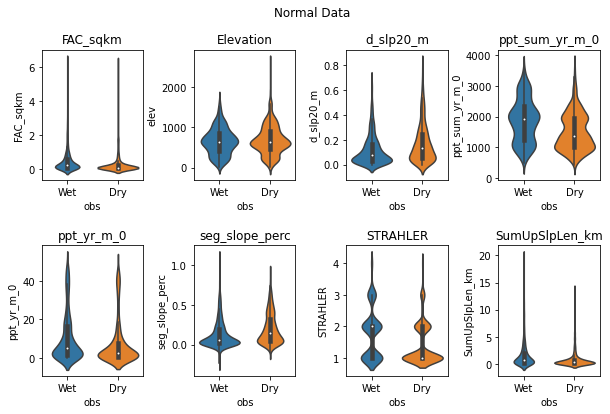

In [112]:
fig, ax = plt.subplots(2,4, figsize = (10,6))
ax = ax.flatten()

sns.violinplot(x='obs', y='FAC_sqkm', data=normal_data, ax=ax[0], label = 'FAC_sqkm')
sns.violinplot(x='obs', y='elev', data=normal_data, ax=ax[1], label = 'Elev')
sns.violinplot(x='obs', y='d_slp20_m', data=normal_data, ax=ax[2], label = 'd_slp20_m')
sns.violinplot(x='obs', y='ppt_sum_yr_m_0', data=normal_data, ax=ax[3], label = 'Elev')
sns.violinplot(x='obs', y='ppt_yr_m_0', data=normal_data, ax=ax[4], label = 'Elev')
sns.violinplot(x='obs', y='seg_slope_perc', data=normal_data, ax=ax[5], label = 'Elev')
sns.violinplot(x='obs', y='STRAHLER', data=normal_data, ax=ax[6], label = 'Elev')
sns.violinplot(x='obs', y='SumUpSlpLen_km', data=normal_data, ax=ax[7], label = 'Elev')

ax[0].set_title('FAC_sqkm')
ax[1].set_title('Elevation')
ax[2].set_title('d_slp20_m')
ax[3].set_title('ppt_sum_yr_m_0')
ax[4].set_title('ppt_yr_m_0')
ax[5].set_title('seg_slope_perc')
ax[6].set_title('STRAHLER')
ax[7].set_title('SumUpSlpLen_km')

fig.subplots_adjust(hspace=0.5,wspace=0.5)
fig.suptitle('Normal Data')

plt.savefig('normal_data')

# AutoEncoder

Once the data is flagged as anomly or not, train the data on the normal non anomolous data and test on the flagged data.

Would be a realtime anomoly detector for future data

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold.

Calculate the mean average error for normal examples from the training data, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training data.

In [232]:
import tensorflow as tf

In [233]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder,LabelEncoder

In [234]:
anomaly_sample = pd.concat([anomalies]*int((len(data[data.anomaly==1])/len(data[data.anomaly==-1]))-1), ignore_index=True)

In [236]:
anomaly_sample

,ID,obs,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km,anomaly
0,1529,Wet,15.723049,254.702469,0.006439,777.101562,3.155749,0.006860,4,53.912409,-1
1,1530,Wet,7.739100,289.862122,0.004159,757.118774,3.125610,0.037506,4,24.736420,-1
2,1532,Dry,4.051450,354.428833,0.020584,776.714722,3.090779,0.050379,3,16.954465,-1
3,1533,Dry,33.766476,334.247162,0.014096,775.579346,3.139964,0.018092,4,123.106017,-1
4,1546,Wet,39.007450,319.913300,0.035834,859.324707,5.494297,0.034281,5,158.811139,-1
...,...,...,...,...,...,...,...,...,...,...,...
1785,1325,Wet,0.726225,298.355042,0.512149,3082.601318,12.003325,0.031985,3,4.049752,-1
1786,1329,Wet,0.768825,924.545532,0.868367,3146.742676,9.426083,0.082899,2,1.716263,-1
1787,456,Wet,10.046675,35.693836,0.039999,1018.267456,25.464037,0.055327,1,23.565045,-1
1788,457,Wet,0.277525,102.153717,0.360407,917.575012,23.823397,-0.588933,1,1.143649,-1


In [237]:
data = pd.concat([data, anomaly_sample], ignore_index=True)

In [239]:
data[data['anomaly']==1]

,ID,obs,FAC_sqkm,elev,d_slp20_m,ppt_sum_yr_m_0,ppt_yr_m_0,seg_slope_perc,STRAHLER,SumUpSlpLen_km,anomaly
0,1521,Wet,0.017350,495.685852,0.191701,907.394043,1.760924,0.143396,1,0.213852,1
1,1522,Wet,0.188075,493.571167,0.182880,893.925049,2.039627,0.114214,2,0.791475,1
2,1523,Wet,0.279025,527.804443,0.282713,884.830017,1.130813,0.027854,2,0.888181,1
3,1524,Wet,1.327500,331.478577,0.001914,903.159729,1.332044,-0.000350,3,4.923404,1
4,1525,Wet,1.108325,355.276337,0.060223,901.722046,1.309967,0.099989,3,4.146109,1
...,...,...,...,...,...,...,...,...,...,...,...
2600,1229,Wet,1.772050,180.377106,0.007826,1987.466064,14.422233,0.000000,3,8.286954,1
2601,1230,Wet,0.041275,208.910355,0.242794,2762.189453,15.028871,0.007385,1,0.288175,1
2602,1231,Wet,0.096825,218.520081,0.114993,2064.167480,14.570926,0.043012,1,0.208603,1
2603,1232,Wet,0.012350,211.710831,0.429275,2475.022217,14.767077,0.712601,1,0.144373,1


In [240]:
X = data.drop(['obs','ID','STRAHLER','anomaly'],axis=1)
y = data['anomaly']

In [241]:
X=X.values
y=y.values

In [242]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [243]:
encoder=LabelEncoder()

In [244]:
# turn -1 and 1 to 0 and 1 ( 0 = anomaly, 1=normal)
y_test = encoder.fit_transform(y_test)
y_train = encoder.fit_transform(y_train)

In [245]:
# Scale the data 
min_val = tf.reduce_min(X_train)
max_val = tf.reduce_max(X_train)

X_train = (X_train - min_val) / (max_val - min_val)
X_test = (X_test - min_val) / (max_val - min_val)
# convert to tensor flow 
X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)

In [246]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

# trainig and test sets that consist of only normal data
X_train_normal = X_train[y_train]
X_test_normal = X_test[y_test]

# training and test sets that consist of only anomalys
X_train_anom = X_train[~y_train]
X_test_anom = X_test[~y_test]

In [247]:
class AnomalyDetector(Model):
    
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(4, activation="relu"),
          layers.Dense(2, activation="relu")])
          

        self.decoder = tf.keras.Sequential([
          layers.Dense(4, activation="relu"),
          layers.Dense(7, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [248]:
autoencoder.compile(optimizer='adam', loss = losses.MeanSquaredError())

In [249]:
iters = autoencoder.fit(X_train_normal,X_train_normal,
               epochs=50,
               shuffle=True,
               validation_data =(X_test, X_test))

Epoch 1/50
53/53 [==============================] - 1s 3ms/step - loss: 0.1914 - val_loss: 0.1811
Epoch 2/50
53/53 [==============================] - 0s 1ms/step - loss: 0.1691 - val_loss: 0.1582
Epoch 3/50
53/53 [==============================] - 0s 1ms/step - loss: 0.1425 - val_loss: 0.1348
Epoch 4/50
53/53 [==============================] - 0s 1ms/step - loss: 0.1178 - val_loss: 0.1138
Epoch 5/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0966 - val_loss: 0.0947
Epoch 6/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0777 - val_loss: 0.0773
Epoch 7/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0611
Epoch 8/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0450 - val_loss: 0.0465
Epoch 9/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0344
Epoch 10/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0210 - val_loss: 0.0262
Epoch 11/50
53/53 [

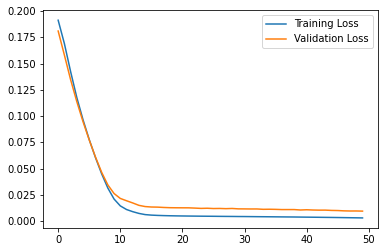

In [250]:
plt.plot(iters.history['loss'], label='Training Loss')
plt.plot(iters.history["val_loss"], label="Validation Loss")
plt.legend()

In [251]:
encoded_data = autoencoder.encoder(X_test_normal).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

In [252]:
reconstructions = autoencoder.predict(X_train_normal)
train_loss = tf.keras.losses.mae(reconstructions, X_train_normal)

53/53 [==============================] - 0s 596us/step


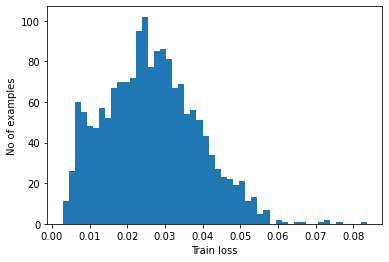

In [253]:
# Histogram of the reconstruction error on training data
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [259]:
# establish a threshold of 2*std greater than the mean
threshold = np.mean(train_loss) + 2*np.std(train_loss)
threshold

0.05108899809420109

18/18 [==============================] - 0s 760us/step


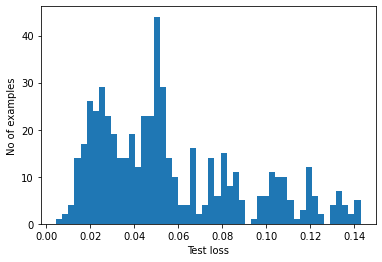

In [260]:
reconstructions = autoencoder.predict(X_test_anom)
test_loss = tf.keras.losses.mae(reconstructions, X_test_anom)
plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [261]:
def predict(model, data, threshold):
    
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold) # classifies data greater than the threshold as an anomaly

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    print("MCC = {}".format(matthews_corrcoef(labels, predictions)))

In [262]:
preds = predict(autoencoder, X_test, threshold)
print_stats(y_test, preds)
confusion_matrix(y_test,preds)

Accuracy = 0.7197452229299363
Precision = 0.9891696750902527
Recall = 0.6447058823529411
MCC = 0.5196063142163999


array([[243, 302],
       [  6, 548]], dtype=int64)

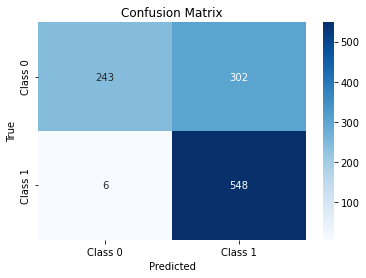

In [263]:
import seaborn as sns

cm = confusion_matrix(y_test,preds)

class_labels = ['Class 0', 'Class 1']

cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Final Remarks

The datasets produced by the Isolation Forest model will need to be more deeply investigated, likley manually, to determine whether or not they are indeed anomalies.

Once they are investigated and a final dataset of anomalies can be produced the autoencoder will be highly usefull and would eliminate the need for such in-depth investigation into anomalies in future data.

